# Master thesis - Datacentric aproach to time series forecasting 

Authors:
- Berling Gustav - gusbe498@student.liu.se
- Janzén Albin - albja295@student.liu.se

Import libraries, data and set global parameters

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import IPython.display
from matplotlib.patches import Rectangle
import scipy

# Set random seed for reproducibility
tf.random.set_seed(1234)
tf.keras.utils.set_random_seed(1234)

# Load the dataset from CSV file
og_df = pd.read_csv('data/Structured/all_data.csv')

#Plot colors
colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']

C:\Users\albin\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3442: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Remove empty data and change order of columns

In [43]:
#Drop all empty columns
df = og_df.dropna(axis=1, how='all')
del og_df
df.drop(['Summa gas/Diesel'], axis=1, inplace=True)

#Fill missing values with the previous value
df = df.fillna(method='ffill')
#Fill missing values with the next value
df = df.fillna(method='bfill')
#Remove collumns with only one value
for e in df.columns:
    if df[e].nunique() == 1:
        df = df.drop(e, axis=1)

#Change index of target variable  
first_column = df.pop('SE1')
df.insert(1, 'SE1', first_column)

#Set date for end of test data
test_end = df[df['Date'] == '2018-01-01 23:00:00'].index.values[0]

#Remove dates from dataframe
dates = df.pop('Date')

#Save number of features
n_features = df.shape[1]
print(n_features)

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

C:\Users\albin\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3382: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if await self.run_code(code, result, async_=asy):


470


Plot target variable

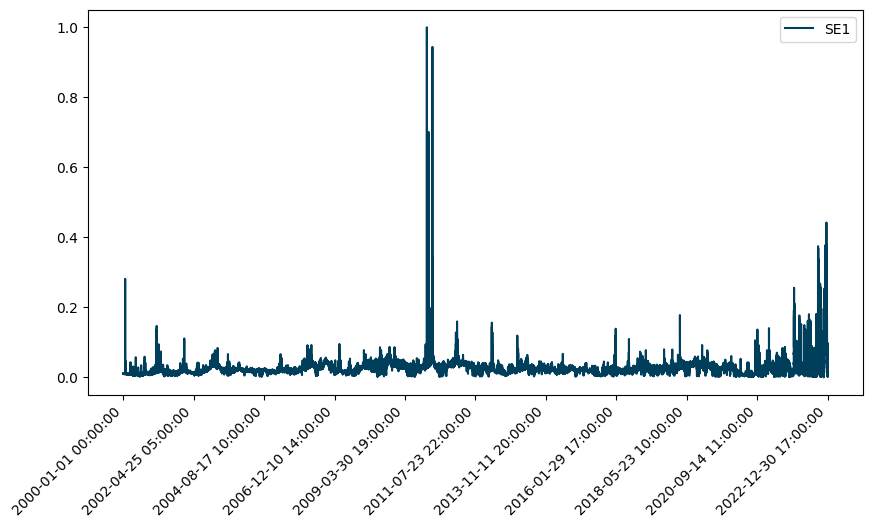

In [3]:
y = df['SE1']
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y, color=colors[0], label='SE1')
ax.legend()
ax.set_xticks(np.arange(0, len(dates), len(dates)//10))
ax.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
plt.show()

Divide train, validation and test set

In [44]:

# Split the dataset into training and testing sets
test_size = int(len(df) * 0.05)
val_size = int(len(df) * 0.1)
val_end = test_end - test_size

train_df = df[:val_end-val_size]
train_dates = dates[:val_end-val_size]

val_df = df[val_end-val_size:val_end]
val_dates = dates[val_end-val_size:val_end]

test_df = df[test_end-test_size:test_end]
test_dates = dates[test_end-test_size:test_end]

train_df = pd.concat([train_df, df[test_end:]])
train_dates = pd.concat([train_dates, dates[test_end:]])

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(172448, 470)
(20287, 470)
(10143, 470)


Select target variable and lag the data for forecasting

In [45]:

lag = 1

train_df = train_df.to_numpy()
# print(train_df.shape)
val_df = val_df.to_numpy()
test_df = test_df.to_numpy()
X_train = np.reshape(train_df, (train_df.shape[0], 1, train_df.shape[1]))
y_train = train_df[:,0]

#shift the data
X_train = X_train[:-lag]
train_dates = train_dates[:-lag]
y_train = y_train[lag:]

X_val = np.reshape(val_df, (val_df.shape[0], 1, val_df.shape[1]))
y_val = val_df[:,0]

#shift the data
X_val = X_val[:-lag]
val_dates = val_dates[:-lag]
y_val = y_val[lag:]

X_test = np.reshape(test_df, (test_df.shape[0], 1, test_df.shape[1]))
y_test = test_df[:,0]

#shift the data
X_test = X_test[:-lag]
test_dates = test_dates[:-lag]
y_test = y_test[lag:]

Adapt the data to the batching

In [46]:
batch_size = 128
print(X_train.shape)
# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train]
y_train = y_train[:num_samples_train]
train_dates = train_dates[:num_samples_train]

X_val = X_val[:num_samples_val]
y_val = y_val[:num_samples_val]
val_dates = val_dates[:num_samples_val]

X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]
test_dates = test_dates[:num_samples_test]

# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0

(172447, 1, 470)


Plot the data split (only target variable is shown but is done on the whole dataset)

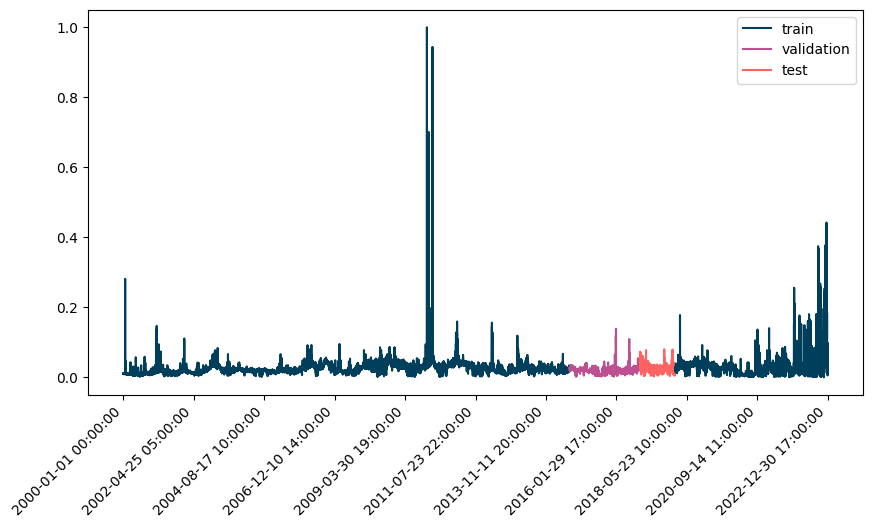

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(0,val_end-val_size), y_train[0:val_end-val_size], color=colors[0], label='train')
ax.plot(np.arange(val_end-y_val.shape[0], val_end), y_val, color=colors[2], label='validation')
ax.plot(np.arange(test_end-y_test.shape[0], test_end), y_test, color=colors[3], label='test')
ax.plot(np.arange(test_end,(test_end + y_train[val_end-val_size:].shape[0])), y_train[val_end-val_size:], color=colors[0])
ax.set_xticks(np.arange(0, len(dates), len(dates)//10))
ax.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
ax.legend()
plt.show()

Create the LSTM model

In [8]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, batch_input_shape=(batch_size, None, n_features), stateful=True),
    tf.keras.layers.Dense(1)
])

Class for plotting the learning process, used as a callback for the compile function of the model

In [9]:

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        IPython.display.clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric, color=colors[0])
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric, color=colors[3])
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

Compile and fit the model: train the model

In [10]:
def compile_and_fit(model, X_train, y_train, patience=10):
  tf.keras.backend.clear_session()
  model.reset_states()
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    restore_best_weights=True,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
  model.build(X_train.shape)
  print(model.summary())
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=batch_size, verbose=1,
                      callbacks=[early_stopping,PlotLearning()])
  return history

# Data Analysis functions

feature_cutoff: Plot and calculate data cutoff based on mae impact

In [11]:
def feature_cutoff(baseline_mae, n_cols, iteration, cutoff = 0, prime = 0):
    df = pd.read_csv(iteration + '_feature_importance.csv', header=None, names=['feature','mae'])
    df = df.sort_values('mae')

    plt.figure(figsize=(10,n_cols//5))
    plt.barh(np.arange(n_cols + 1),df.mae, color=colors[0])
    plt.yticks(np.arange(n_cols + 1),df.feature.values)
    plt.title('LSTM Feature Importance',size=16)
    plt.ylim((-1,n_cols + 1))

    plt.plot([baseline_mae,baseline_mae],[-1,n_cols + 1], '--', color=colors[4],
                label=f'Baseline \nMAE={baseline_mae:.4f}')
    a_set_columns = [] 
    b_set_columns = []
    prime_set_columns = []

    df = df[df.feature != 'Baseline']

    if cutoff != 0:
        if cutoff == 1:
            cutoff = np.std(df[df['mae'] < baseline_mae]).mae
        a_set_columns = df[df['mae'] >= baseline_mae - cutoff].feature
        b_set_columns = df[df['mae'] < baseline_mae - cutoff].feature
        plt.plot([baseline_mae-cutoff,baseline_mae-cutoff],[-1,n_cols+1], '--', color=colors[1],
                    label=f'Cutoff threshold\nMAE={baseline_mae-cutoff:.4f}')

    if prime != 0:
        if prime == 1:
            prime = np.std(df[df['mae'] > baseline_mae]).mae
        prime_set_columns = df[df['mae'] > baseline_mae + prime].feature
        plt.plot([baseline_mae+prime,baseline_mae+prime],[-1,n_cols+1], '--', color=colors[3],
                    label=f'Cutoff threshold\nMAE={baseline_mae+prime:.4f}')

    plt.ylabel('Feature',size=14)
    plt.legend()
  
    plt.show()
    return a_set_columns, b_set_columns, prime_set_columns

unique_average: Compute the average number of features that has low data uniqueness

In [12]:
def unique_average(data):
    list = []
    for i in range(data.shape[1]):
        list.append(data.iloc[:,i].nunique())
    list = pd.DataFrame(list)
    print('Average amount of unique values per feature:')
    print(np.mean(list))
    print('Average percentage of unique values per feature:')
    print(np.mean(list)/data.shape[0])
    plt.plot(list, color=colors[0], label='Unique values')
    plt.legend()

boxplot: Create a boxplot

In [13]:
def boxplot(data, columns):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, columns.shape[0]//5))

    meds = data.median()
    meds.sort_values(ascending=False, inplace=True)
    data = data[meds.index]

    bplot1 = ax1.boxplot(data, vert=False, patch_artist=True, labels=columns)  

    plt.setp(bplot1["boxes"], facecolor=colors[0])
    plt.setp(bplot1["whiskers"], color=colors[2])
    plt.setp(bplot1["fliers"], markeredgecolor=colors[4])
    plt.show()

feature_importance: Calculate feature importance

In [14]:
import os
def feature_importance(model, X, y, df, batch_size, iteration):
    n_permutations = 5
    COLS = list(df.columns[1:])
    n_cols = len(COLS)
    print('Computing LSTM feature importance...')

    preds = model.predict(X, verbose=0, batch_size=batch_size).squeeze() 
    baseline_mae = np.mean(np.abs( preds-y ))
    print(baseline_mae)
    if not os.path.exists(iteration + '_feature_importance.csv'):
        fi_df = pd.DataFrame(['Baseline', baseline_mae]).T
        fi_df.to_csv(iteration + '_feature_importance.csv', index=False, header=False)
        for k in range(n_cols):
            save_col = X[:,:,k].copy()
            if k % 50 == 0:
                print(k)
            mae_list = np.zeros(n_permutations)
            
            for i in range(n_permutations):
                X[:,:,k] = np.random.permutation(X[:,:,k])
                preds = model.predict(X, verbose=0, batch_size=batch_size).squeeze() 
                mae_list[i] = np.mean(np.abs( preds-y ))
            
            mae = np.mean(mae_list) 
            fi_df = pd.DataFrame([COLS[k], mae]).T
            fi_df.to_csv(iteration + '_feature_importance.csv', mode='a', index=False, header=False)
            X[:,:,k] = save_col
    
    return baseline_mae, n_cols

time_slice_mae_plot: plot the mae over batch time slices

In [15]:
def time_slice_mae_plot(model, X, y, batch_size, dates):
    assert X.shape[0] % batch_size == 0
    n_batches = int(X.shape[0] / batch_size)
    print(n_batches)
    time_slice_mae = pd.DataFrame(np.zeros(n_batches), columns=['mae'])
    for i in range(n_batches):
        data = X[i*batch_size:(i+1)*batch_size,:,:]
        preds = model.predict(data, verbose=0, batch_size=batch_size).squeeze() 
        time_slice_mae.iloc[i] = np.mean(np.abs(preds-y[i*batch_size:(i+1)*batch_size]))
    time_slice_mae.reset_index(drop=True, inplace=True)

    pred = model.predict(X, verbose=0, batch_size=batch_size).squeeze()

    x_index = np.arange(0, y.shape[0], batch_size)

    fig,(ax, ax2)  = plt.subplots(1,2, figsize=(20, 5))
    
    ax.set_ylabel("SE1",
                fontsize=14, color='grey')

    ax.fill_between(
        np.arange(0,len(pred)), pred, y, where=(pred > y), 
        interpolate=True, color=colors[2], alpha=1, 
        label="Larger forecast", zorder=2
    )
    ax.fill_between(
        np.arange(0,len(pred)), pred, y, where=(pred < y), 
        interpolate=True, color=colors[0], alpha=1, 
        label="Lower forecast", zorder=2
    )
    
    ax.set_xticks(np.arange(0, len(dates), len(dates)//10))
    ax.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
    ax.legend()
    ax2.plot(x_index, time_slice_mae, color=colors[0], label='Slice MAE')
    std_dev = np.std(time_slice_mae).mae + np.mean(time_slice_mae).mae
    ax2.axhline(y=std_dev, color=colors[4])
    ax2.set_xticks(np.arange(0, len(dates), len(dates)//10))
    ax2.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
    ax2.legend()
    plt.show()

    result = time_slice_mae['mae'] > std_dev
    return result, pred


getSlices: get the interesting slices to analyse

In [16]:
def getSlices(X, y, batch_slices, batch_size, preds, dates):
    indices = []
    n_batches = int(X.shape[0] / batch_size)
    for i in range(n_batches):
            if batch_slices[i]:
                    indices.append({'from': i*batch_size, 'to': i*batch_size+batch_size})
    slices = []

    from_index = indices[0]['from']
    to_index = indices[0]['to']
    last_loop_in_range = False

    for i in range(len(indices)-1):
        if indices[i+1]['from'] - indices[i]['to'] < 720:
            to_index = indices[i+1]['to']
            last_loop_in_range = True
        else:
            slices.append({'from': from_index, 'to': to_index})
            from_index = indices[i+1]['from']
            to_index = indices[i+1]['to']
            last_loop_in_range = False

    if last_loop_in_range:
        slices.append({'from': from_index, 'to': to_index})

    fig, ax = plt.subplots(figsize=(20, 12))
    for i in slices:
        ax.add_patch(Rectangle((i['from'], 0), i['to'] - i['from']+128, np.max(y), facecolor='#ffa600', alpha=1, zorder=1))
    
    ax.fill_between(
        np.arange(0,len(preds)), preds, y, where=(preds > y), 
        interpolate=True, color="#bc5090", alpha=1, 
        label="Larger forecast", zorder=2
    )
    ax.fill_between(
        np.arange(0,len(preds)), preds, y, where=(preds < y), 
        interpolate=True, color="#003f5c", alpha=1, 
        label="Lower forecast", zorder=2
    )
    ax.set_xticks(np.arange(0, len(dates), len(dates)//10))
    ax.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
    ax.legend()
    
    plt.show()

    return slices

run_analysis_suite: run the data analysis suite based on the above functions

In [17]:
def run_analysis_suite(data, columns):
    print("Data shape: ")
    print(data.shape)
    unique_average(data)
    boxplot(data, columns)

printSliceMae: print the mae of the interesting slices

In [18]:
def printSliceMae(slices, X, y, model, batch_size):
    for i in slices:
        preds = model.predict(X[i['from']:i['to']], batch_size=batch_size, verbose=0)
        print('steps in slice: ', i['to'] - i['from'], '    mae', np.mean(np.abs(preds-y[i['from']:i['to']])))

# Baseline

## Train Baseline

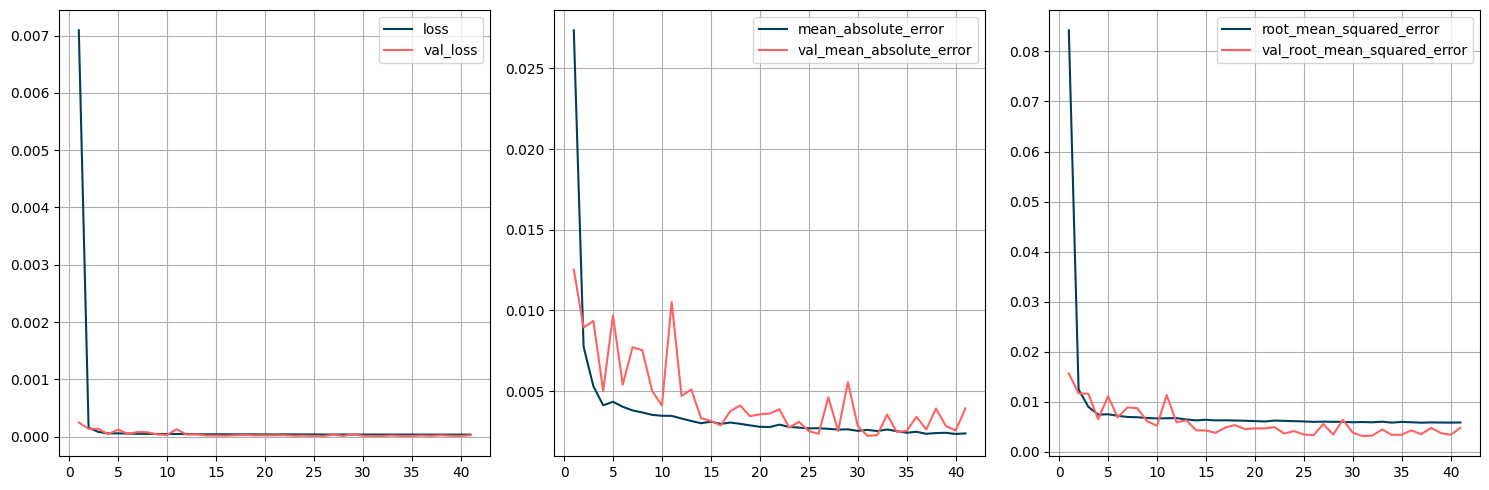

1347/1347 [==============================] - 7s 5ms/step - loss: 3.4209e-05 - mean_absolute_error: 0.0024 - root_mean_squared_error: 0.0058 - val_loss: 2.2829e-05 - val_mean_absolute_error: 0.0039 - val_root_mean_squared_error: 0.0048


In [19]:
history = compile_and_fit(model, X_train, y_train)
model.save_weights('.models/baseline')

## Baseline result/residuals

In [20]:
result = model.predict(X_test, batch_size=batch_size)

79/79 [==============================] - 1s 3ms/step


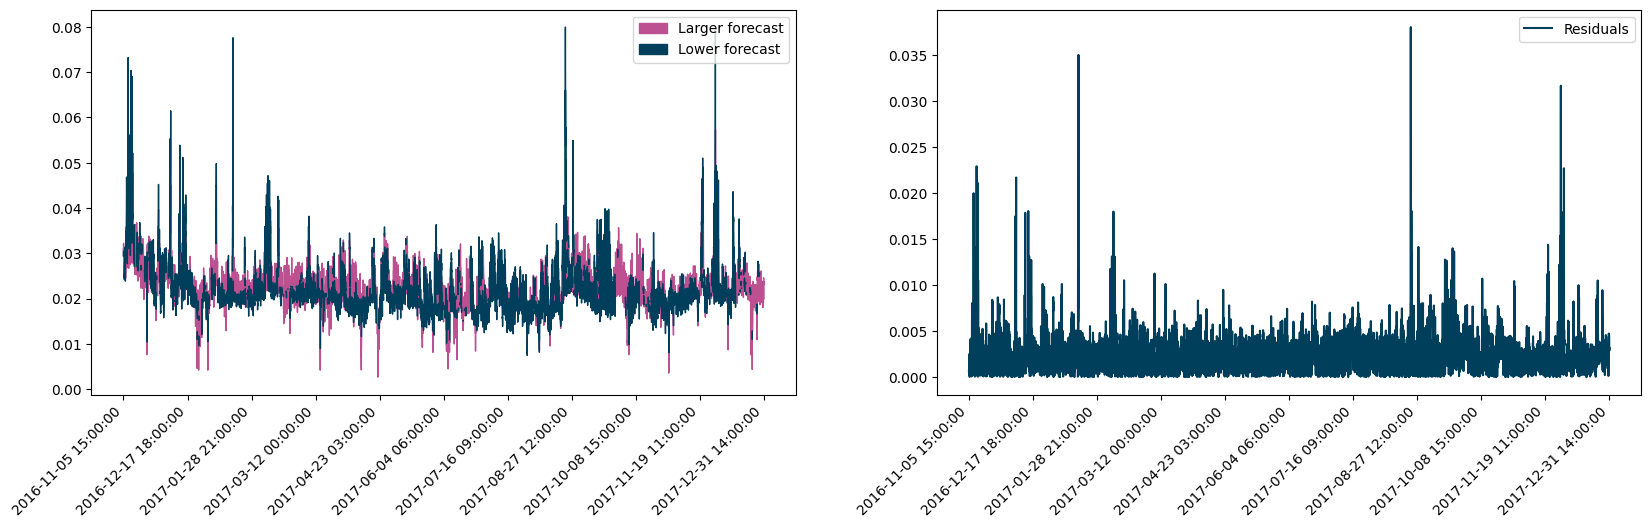

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
result = result.squeeze()
ax1.fill_between(
    np.arange(0,len(result)), result, y_test, where=(result > y_test), 
    interpolate=True, color=colors[2], alpha=1, 
    label="Larger forecast"
)
ax1.fill_between(
    np.arange(0,len(result)), result, y_test, where=(result < y_test), 
    interpolate=True, color=colors[0], alpha=1, 
    label="Lower forecast"
)
ax1.set_xticks(np.arange(0, len(test_dates), len(test_dates)//10))
ax1.set_xticklabels(test_dates[::len(test_dates)//10], rotation=45, ha='right')
residuals = abs(np.subtract(np.array(result), np.array(y_test)))
# residuals = y_test - result
ax1.legend()
ax2.plot(residuals, label='Residuals', color=colors[0])
ax2.legend()
ax2.set_xticks(np.arange(0, len(test_dates), len(test_dates)//10))
ax2.set_xticklabels(test_dates[::len(test_dates)//10], rotation=45, ha='right')
plt.show()

## Baseline feature importance

In [22]:
baseline_mae, n_cols = feature_importance(model, X_val, y_val, df, batch_size, 'baseline')

Computing LSTM feature importance...
0.0022132180347012613


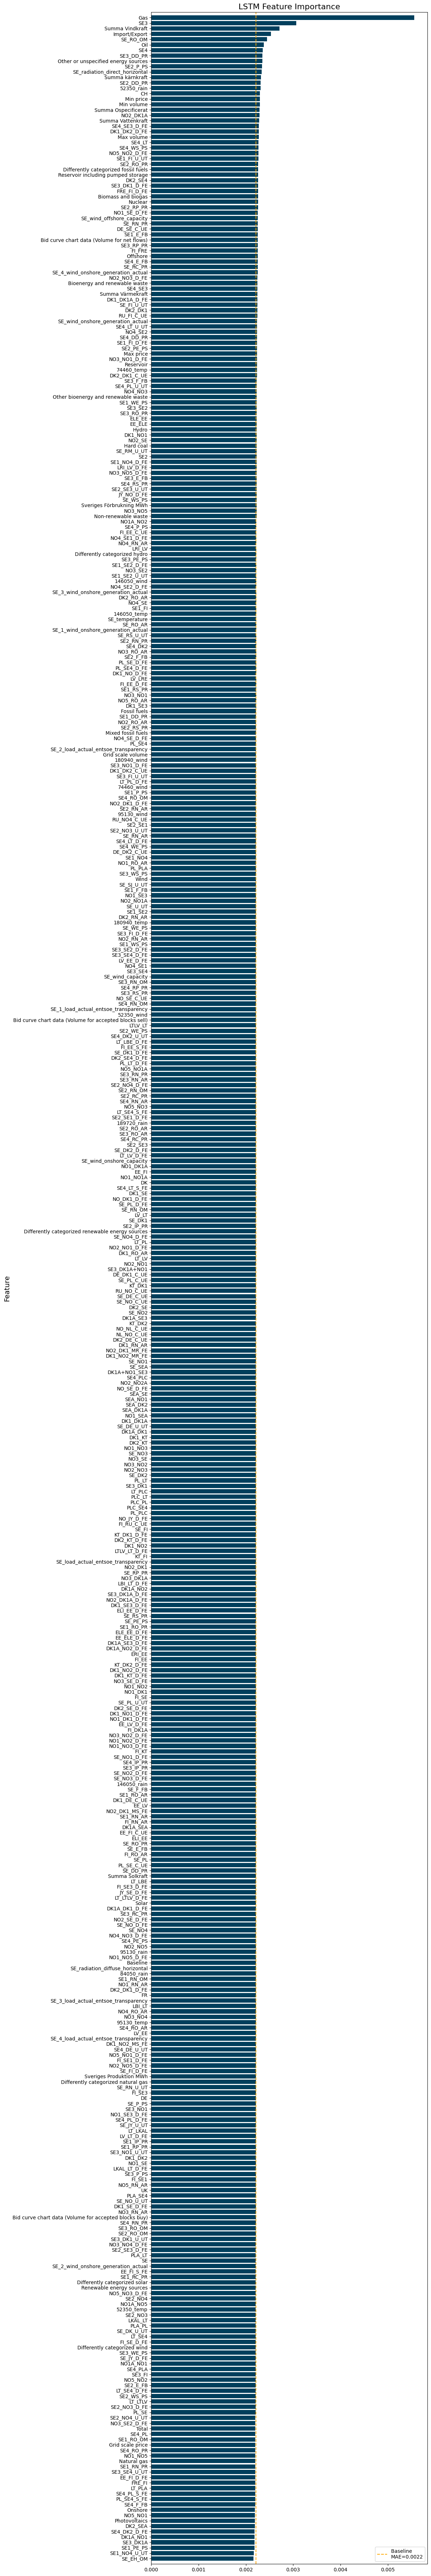

([], [], [])

In [25]:
feature_cutoff(baseline_mae, n_cols, 'baseline', cutoff = 0, prime = 0)

# Iteration 1

Remove unused memory allocations

In [26]:
import gc
gc.collect()

66039

## Feature Importance cutoff

c:\Users\albin\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3579: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


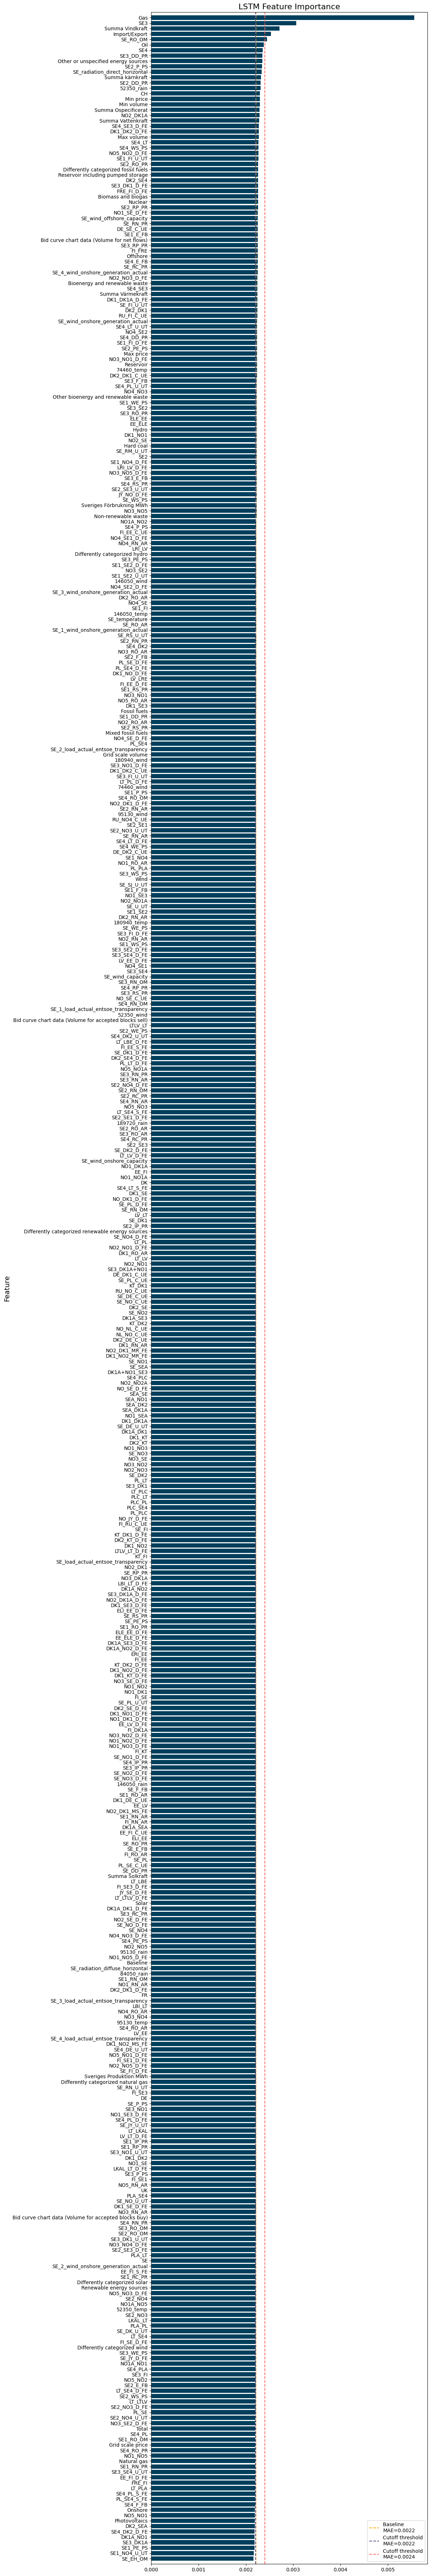

In [27]:
a_set_columns, b_set_columns, prime_set_columns = feature_cutoff(baseline_mae, n_cols, 'baseline', cutoff = 1, prime = 1)

### B set

Data shape: 
(202878, 28)
Average amount of unique values per feature:
0    5397.428571
dtype: float64
Average percentage of unique values per feature:
0    0.026604
dtype: float64


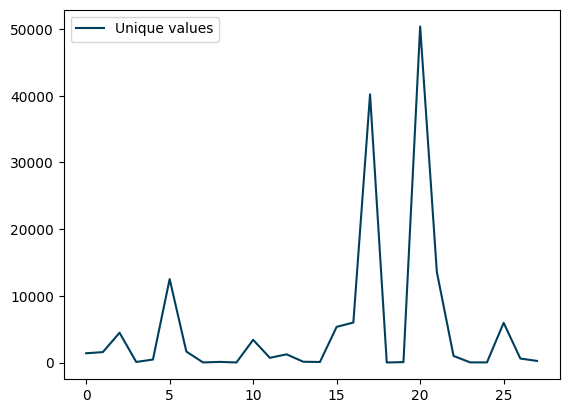

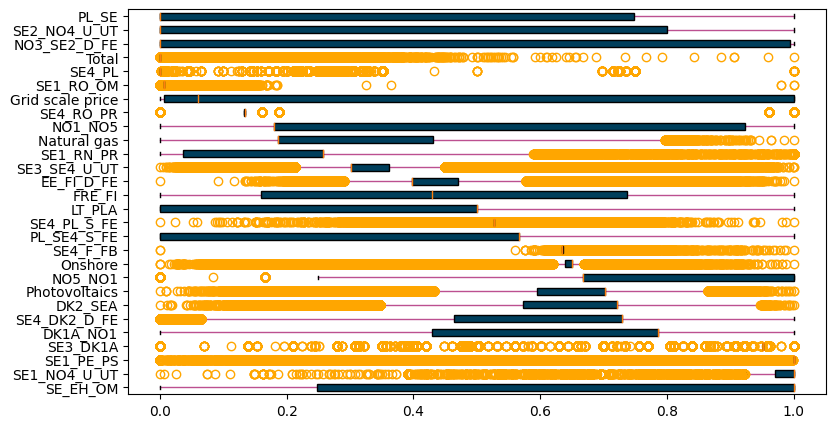

In [28]:
b_set = df[b_set_columns]
run_analysis_suite(b_set, b_set_columns)

### A set

Data shape: 
(202878, 441)
Average amount of unique values per feature:
0    9038.705215
dtype: float64
Average percentage of unique values per feature:
0    0.044552
dtype: float64


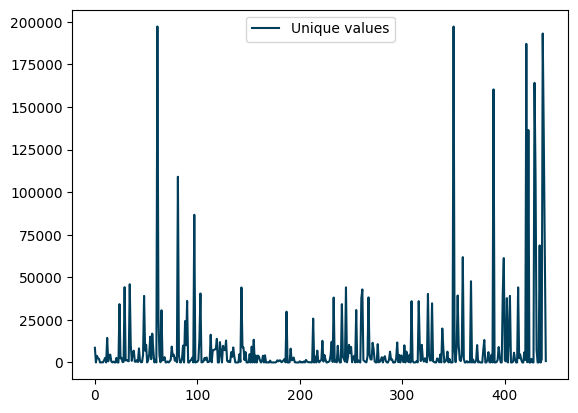

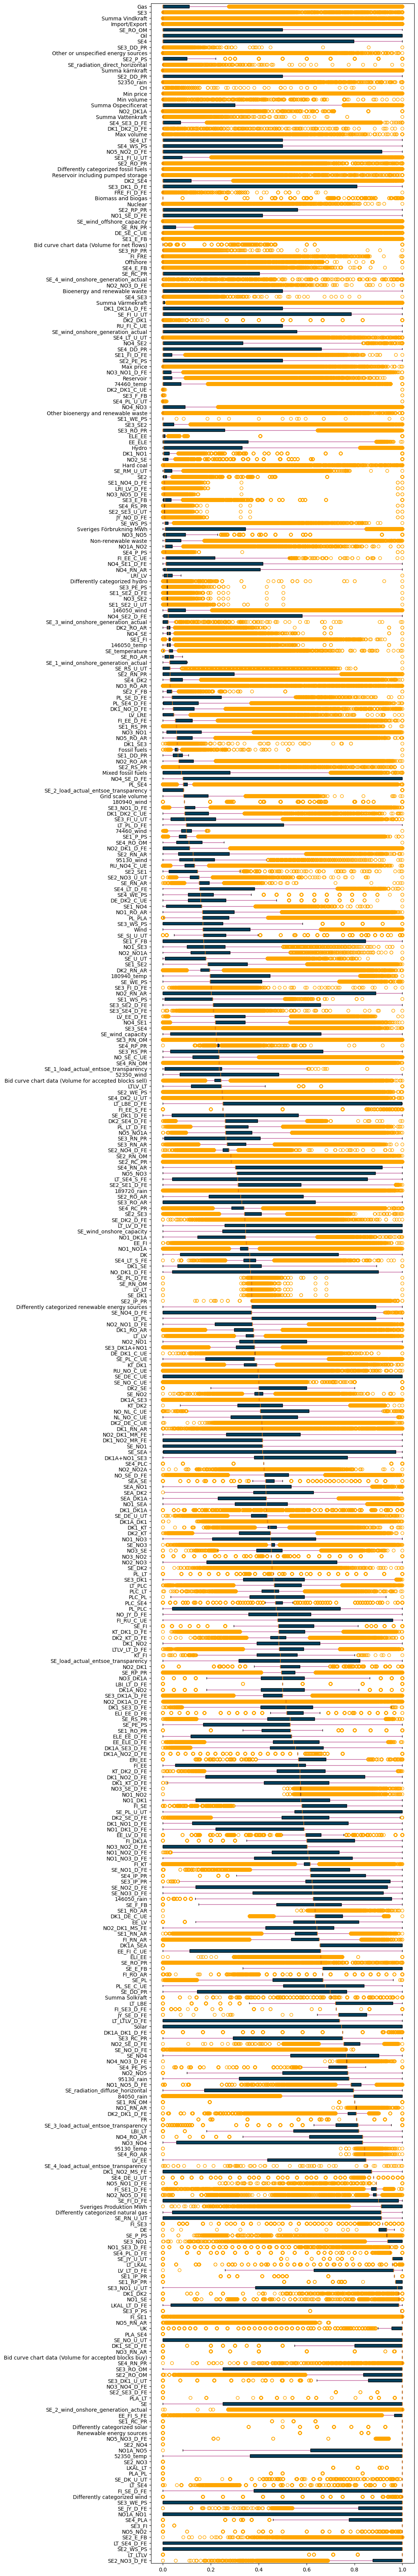

In [29]:
a_set = df[a_set_columns]
run_analysis_suite(a_set, a_set_columns)

### Prime

Data shape: 
(202878, 5)
Average amount of unique values per feature:
0    79297.0
dtype: float64
Average percentage of unique values per feature:
0    0.390861
dtype: float64


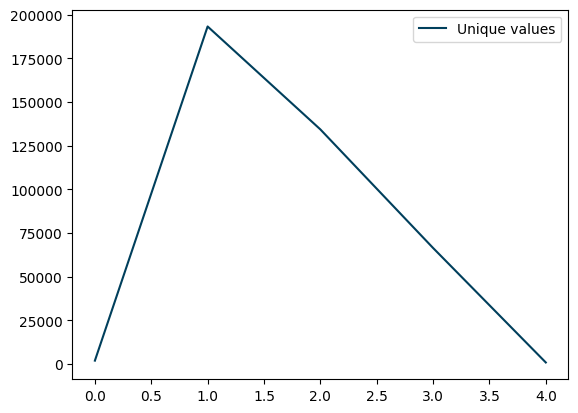

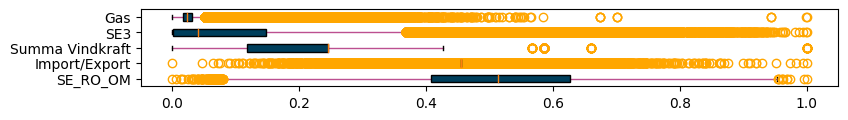

In [30]:
prime_set = df[prime_set_columns]
run_analysis_suite(prime_set, prime_set_columns)

## Time slice selection

Dispose of unused memory

In [31]:
gc.collect()

305256

1347


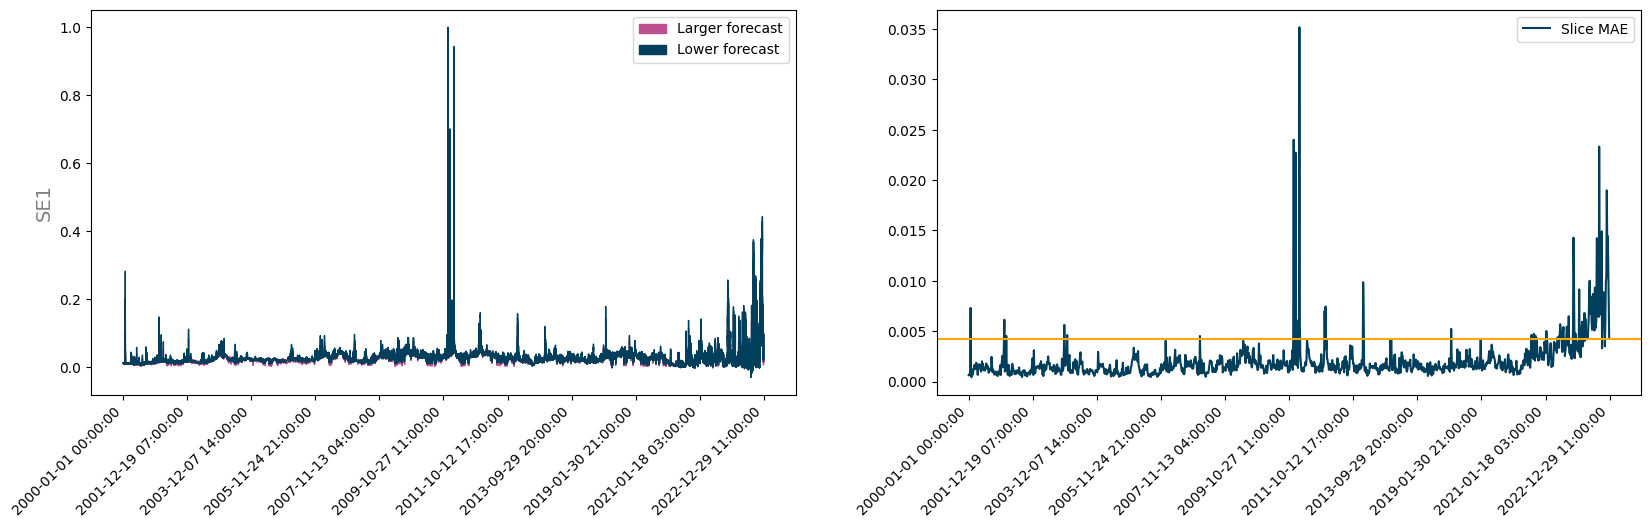

In [32]:
train_interesting_batch_indices, train_preds = time_slice_mae_plot(model, X_train, y_train, batch_size, train_dates)

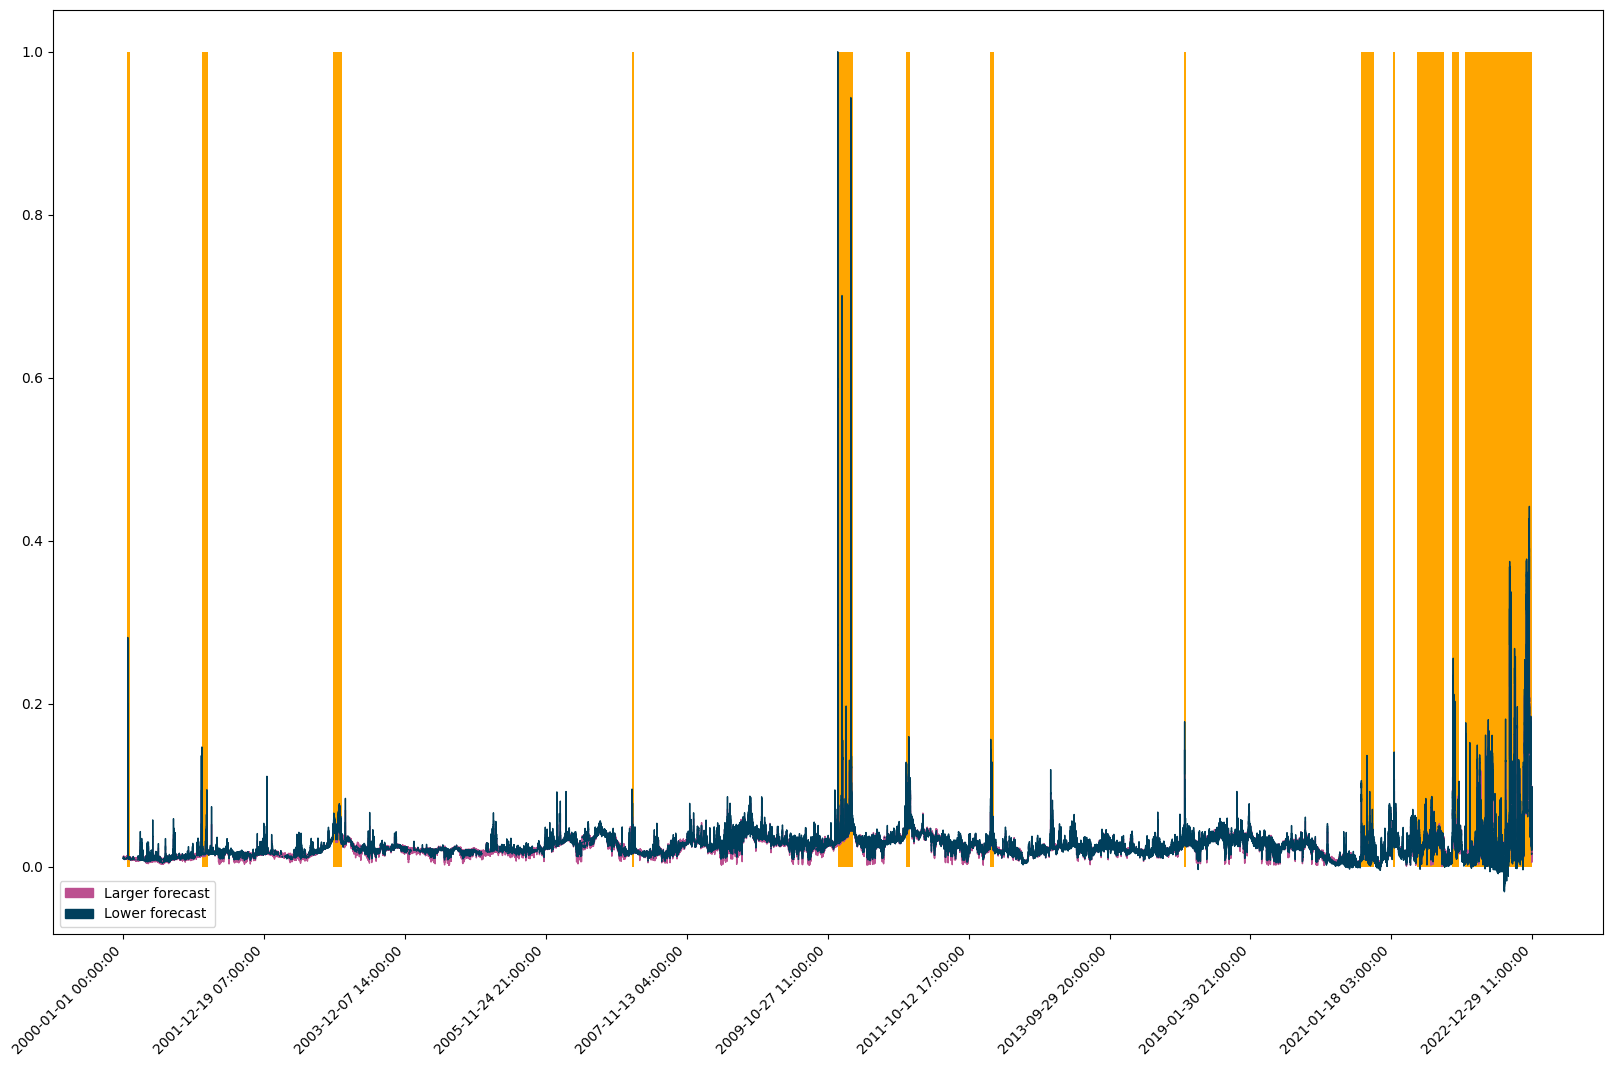

In [33]:
train_slices = getSlices(X_train, y_train, train_interesting_batch_indices, batch_size, train_preds, train_dates)

In [34]:
printSliceMae(train_slices, X_train, y_train, model, batch_size)

steps in slice:  128     mae 0.02100733192406432
steps in slice:  640     mae 0.0065922965591925075
steps in slice:  896     mae 0.011466329853971974
steps in slice:  128     mae 0.008689462149033478
steps in slice:  1792     mae 0.02986080906453763
steps in slice:  384     mae 0.019292470966234015
steps in slice:  256     mae 0.01911707543307728
steps in slice:  128     mae 0.016982887753239344
steps in slice:  1536     mae 0.010532812421040115
steps in slice:  128     mae 0.012778104506795266
steps in slice:  3200     mae 0.012446533862070923
steps in slice:  768     mae 0.04659944704671797
steps in slice:  8064     mae 0.05329640310769425


158


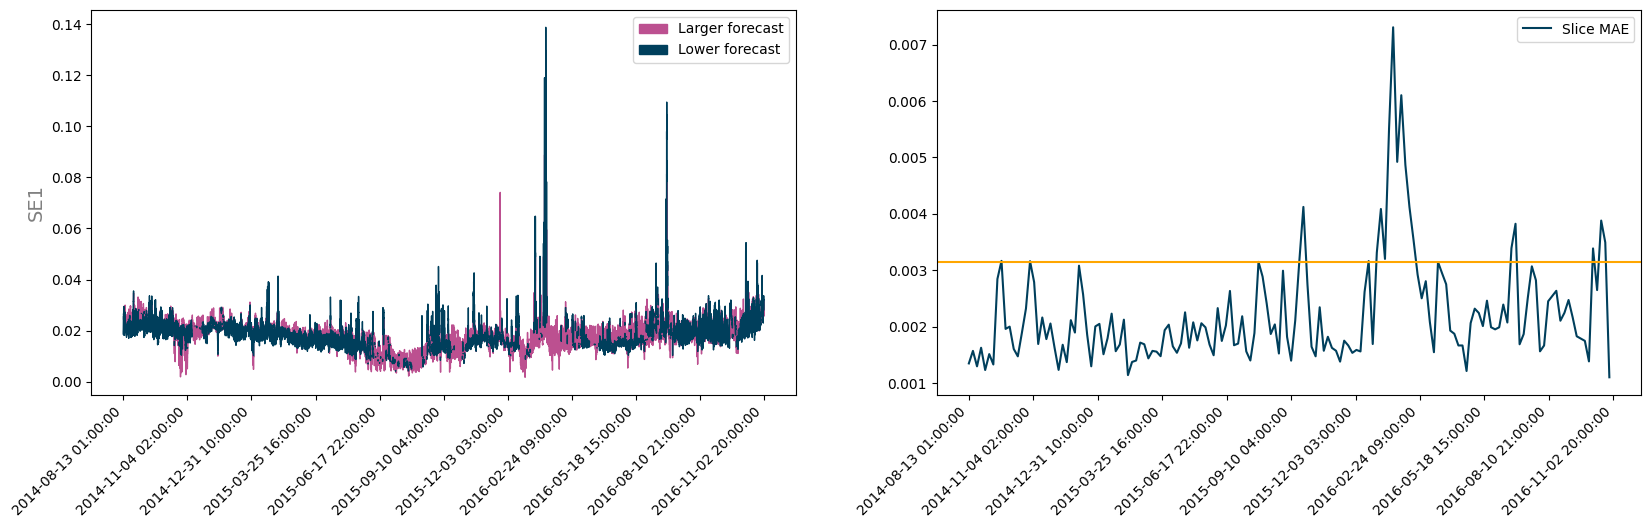

In [35]:
val_interesting_batch_indices, val_preds = time_slice_mae_plot(model, X_val, y_val, batch_size, val_dates)

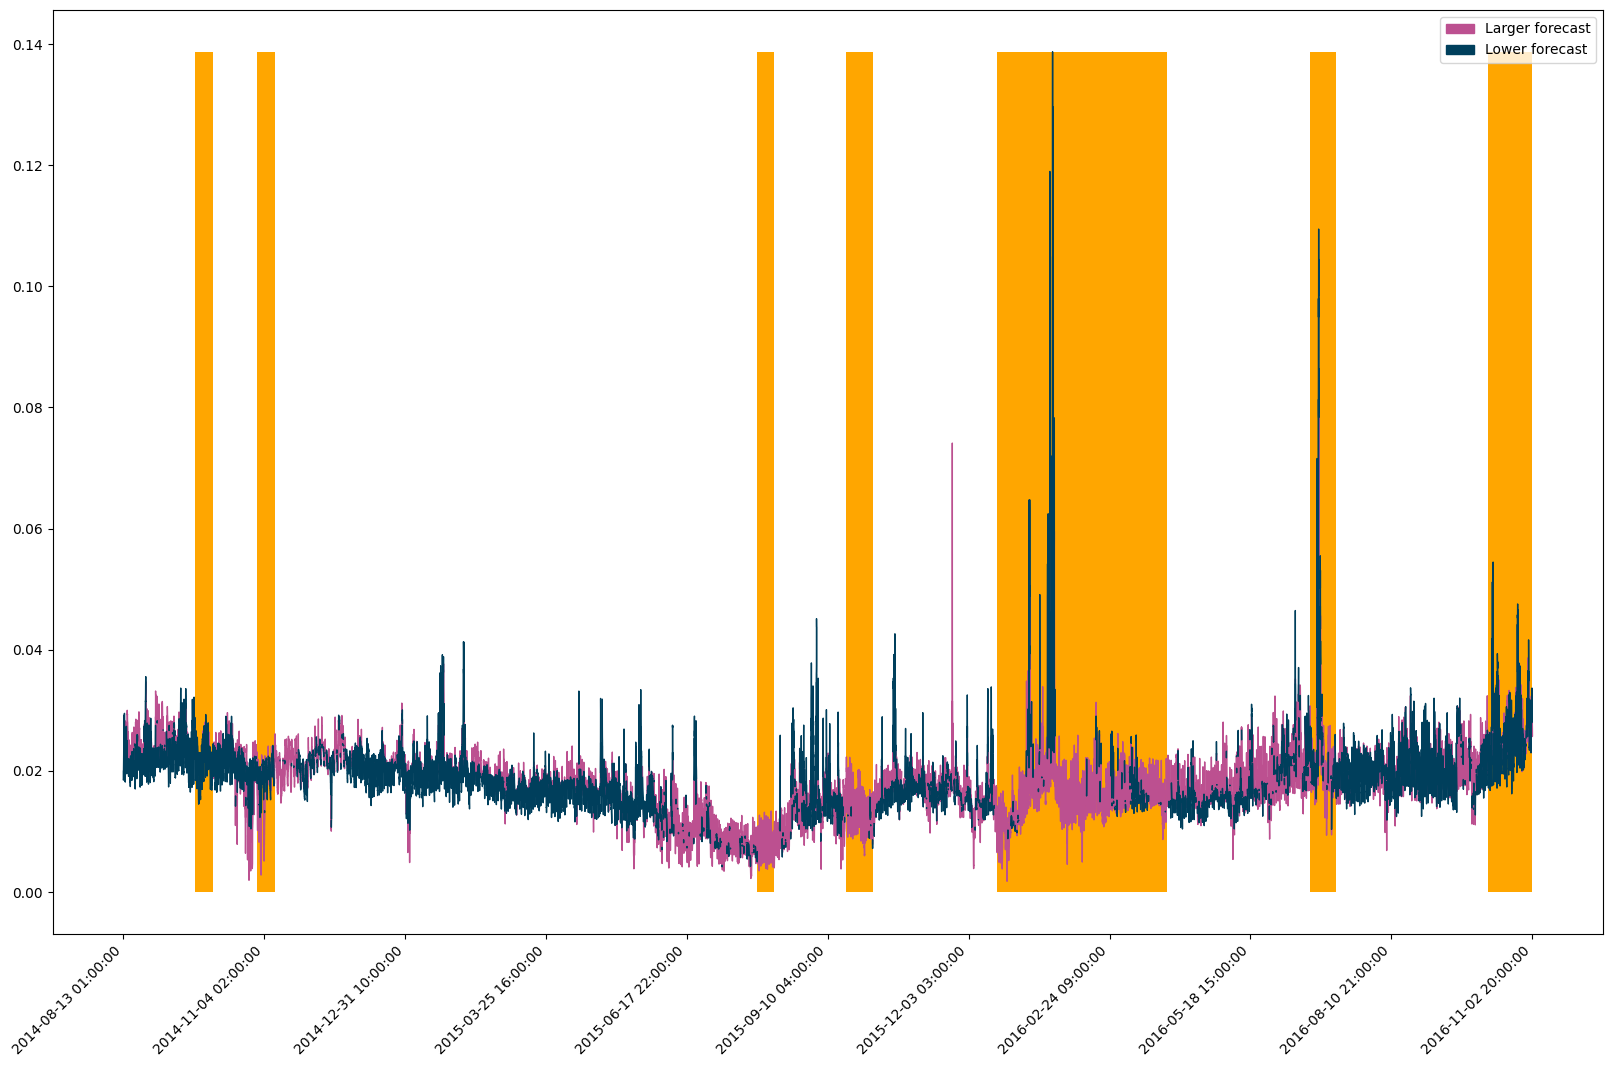

In [36]:
val_slices = getSlices(X_val, y_val, val_interesting_batch_indices, batch_size, val_preds, val_dates)

In [37]:
printSliceMae(val_slices, X_val, y_val, model, batch_size)

steps in slice:  128     mae 0.0040779505842483445
steps in slice:  128     mae 0.005834051809381107
steps in slice:  128     mae 0.003236220453754775
steps in slice:  256     mae 0.004446778352785421
steps in slice:  2304     mae 0.006551502012016982
steps in slice:  256     mae 0.011532376490372667
steps in slice:  512     mae 0.005610906717966932


In [129]:
#print(train_slices)
current_analysis_slice = []
axes = []
x_size = 2
y_size = 3*len(train_slices)
height_ratios = np.ones(y_size)
height_ratios = [2,2,1]*len(train_slices)
print(y_size)
print(len(height_ratios))
print(height_ratios)
fig,(axes) = plt.subplots(y_size,x_size, figsize = (20,60), gridspec_kw={'height_ratios': height_ratios})
count = 0
for x in range(x_size):
    for y in range(y_size):
        print(y, x)
        if count < len(train_slices):
            trainPred = train_preds[train_slices[count]['from']:train_slices[count]['to']]
            trainY = y_train[train_slices[count]['from']:train_slices[count]['to']]
            current_analysis_slice = X_train[train_slices[count]['from']:train_slices[count]['to']]
            if y % 3 == 0:
                colorpicker = plt.cm.jet(np.linspace(0,1,current_analysis_slice.shape[2]))
                for i in range(current_analysis_slice.shape[2]):
                    axes[y,x].plot(current_analysis_slice[:,0,i], alpha = 0.5, linewidth = 0.2, color = colorpicker[i])
            elif y % 3 == 1:
                window = 10
                correlation_difference = np.zeros((current_analysis_slice.shape[0]-window, current_analysis_slice.shape[2]))
                for i in range(current_analysis_slice.shape[2]):
                    for j in range(current_analysis_slice.shape[0]-window):
                        feature_target_correlation = scipy.signal.correlate(current_analysis_slice[j:j+window,0,i], trainY[j:j+window], mode='full', method='auto').max()
                        feature_prediction_correlation = scipy.signal.correlate(current_analysis_slice[j:j+window,0,i], trainPred[j:j+window], mode='full', method='auto').max()
                        correlation_difference[j,i] = feature_target_correlation - feature_prediction_correlation
                axes[y,x].plot(correlation_difference, alpha = 0.5, linewidth = 0.2)
            else:
                axes[y,x].fill_between(
                    np.arange(0,len(trainPred)), trainPred, trainY, where=(trainPred > trainY), 
                    interpolate=True, color=colors[2], alpha=1, 
                    label="Larger forecast",
                )
                axes[y,x].fill_between(
                    np.arange(0,len(trainPred)), trainPred, trainY, where=(trainPred < trainY), 
                    interpolate=True, color=colors[0], alpha=1, 
                    label="Lower forecast",
                )
                count += 1

plt.show()

39
39
[2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1]
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0


https://towardsdatascience.com/anomaly-detection-in-multivariate-time-series-with-network-graphs-80a84deeed9e

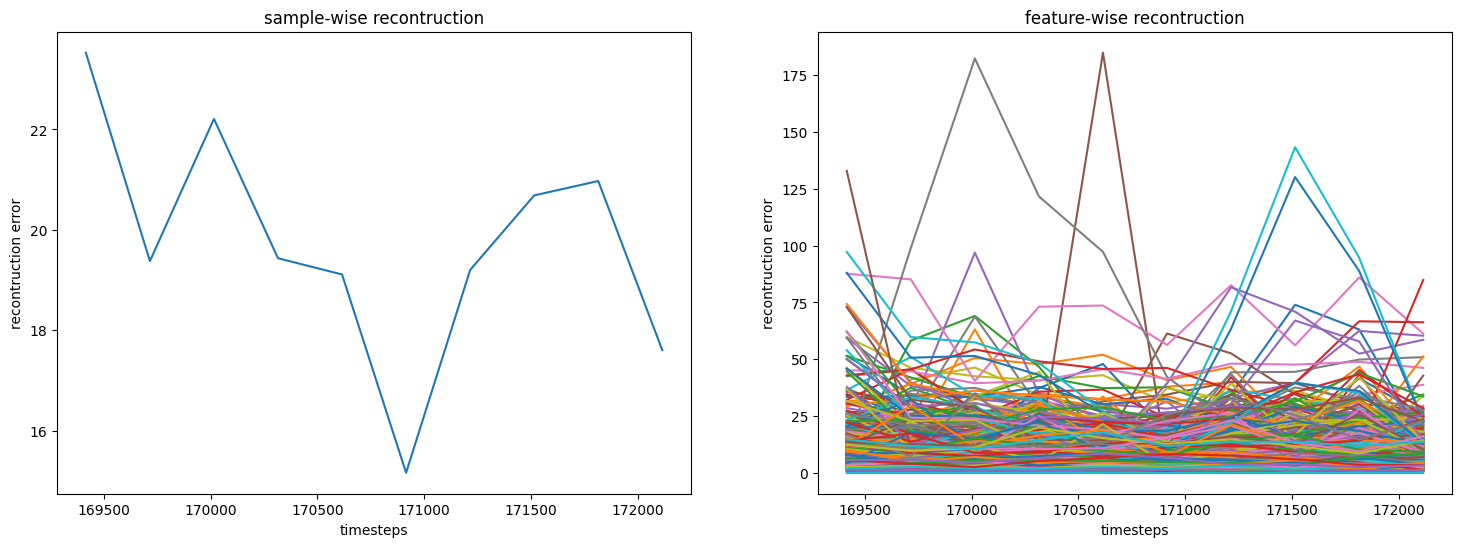

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

X = pd.DataFrame(X_train[:,0,:])

### PCA ANOMALY DETECTION ###

rec_errors_samples = {}
rec_errors_features = {}

for i, (past_id,future_id) in enumerate(
    TimeSeriesSplit(10, test_size=300).split(X)
):
    
    scaler = StandardScaler()
    pca = PCA(0.7, random_state=33)
    pca.fit(scaler.fit_transform(X.iloc[past_id]))
    
    Xt = pca.inverse_transform(
        pca.transform(
            scaler.transform(X.iloc[future_id])
        )
    )
    rec_errors_samples[past_id[-1]] = \
        np.linalg.norm(scaler.transform(X.iloc[future_id]) - Xt, axis=1)
    rec_errors_features[past_id[-1]] = \
        np.linalg.norm(scaler.transform(X.iloc[future_id]) - Xt, axis=0)

### PLOT PCA RECONSTRUCTION ERRORS ###

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(list(rec_errors_samples.keys()), 
         [np.mean(r) for r in rec_errors_samples.values()])
plt.ylabel('recontruction error'); plt.xlabel('timesteps')
plt.title('sample-wise recontruction')

plt.subplot(1,2,2)
for i in range(n_features):
    rec = []
    for r in rec_errors_features.values():
        rec.append(r[i])
    plt.plot(list(rec_errors_features.keys()), rec)
plt.ylabel('recontruction error'); plt.xlabel('timesteps')
plt.title('feature-wise recontruction')

plt.show()

(128, 470)
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89

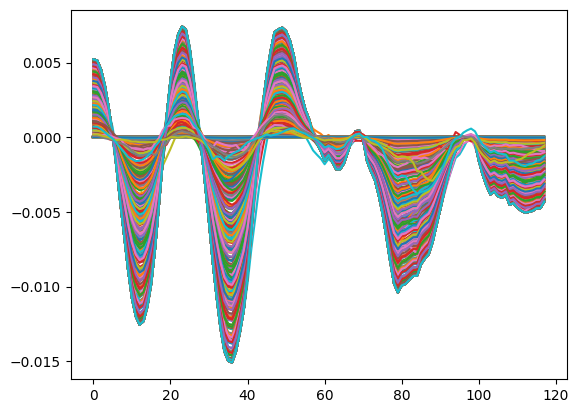

In [90]:
import scipy
gc.collect()
window = 10
correlation_difference = np.zeros((X.shape[0]-window, X.shape[1]))
X = X_train[train_slices[0]['from']:train_slices[0]['to'],0,:]
for i in range(X.shape[1]):
    for j in range(X.shape[0]-window):
        feature_target_correlation = scipy.signal.correlate(X[j:j+window,i], y_train[j:j+window], mode='full', method='auto').max()
        feature_prediction_correlation = scipy.signal.correlate(X[j:j+window,i], train_preds[j:j+window], mode='full', method='auto').max()
        correlation_difference[j,i] = feature_target_correlation - feature_prediction_correlation
plt.plot(correlation_difference)

In [40]:
### DBSCAN ANOMALY DETECTION ###

# network_ano = {}
# dbscan = DBSCAN(eps=0.6, min_samples=1, metric="precomputed")


# for i, (past_id,_) in enumerate(
#     TimeSeriesSplit(10, test_size=300, max_train_size=300).split(X)
# ):
#     print(i)
#     # print(np.isnan(pairwise_distances(X.iloc[past_id].T, metric='correlation')))
#     preds = dbscan.fit_predict(
#         pairwise_distances(X.iloc[past_id].T)
#     )
#     if (preds > 0).any():
#         ano_features = list(X.columns[np.where(preds > 0)[0]])
#         network_ano[past_id[-1]] = ano_features
#     else:
#         network_ano[past_id[-1]] = None
# ### PLOT DBSCAN DETECTED ANOMALIES ###

# print("ok1")
# roll_corr = X.rolling(1).corr()
# print("ok2")
# for ano_loc,ano in network_ano.items():
#     print(ano_loc, ano)
#     if ano is not None:
#         for ano_feat in network_ano[ano_loc]:
#             roll_corr[ano_feat].unstack().plot(
#                 legend=False, figsize=(11,6),
#                 title=f"{ano_feat} rolling correlation",
#                 ylabel='correlation', xlabel='timesteps'
#             )
#             plt.axvline(ano_loc, linestyle='--', c='black')
#             plt.show()

remove b_set from train data

In [41]:
# indexes = [df.columns.get_loc(c) for c in a_set_columns if c in df]
# X_train = X_train[:,:,indexes]
# X_val = X_val[:,:,indexes]
# X_test = X_test[:,:,indexes]